# Install

In [ ]:
pip install image # install's PIL, the python image library
# install portaudio is required by pyaudio (http://portaudio.com/docs/v19-doxydocs/tutorial_start.html)
pip install pyaudio # for recording within python. used for audioSearch module
pip install pygame # for realtime MIDI performance in midi.realtime module
# install muscore for viewing and editing music notation (http://www.musescore.org)
# install lilypond for displaying musical scores (http://lilypond.org/) 

# Import

In [555]:
import os
import numpy as np
import pandas as pd
from StringIO import StringIO

#import pyaudio
import time
import matplotlib.pyplot as plt
%matplotlib inline

import essentia
# there are 2 operating modes in essentia which have the same algorithms:
import essentia.standard
import essentia.streaming

import madmom as mad

import music21 as m21

In [919]:
len(range(36, 96))

60

# Globals

In [979]:
# pitches, notes
NUM_PITCH_CLASS = 12               # C, C#, D, D#, E, F, F#, G, G#, A, A#, B
NUM_MIDI_PITCH = 127               # range of audible sounds
RANGE_PIANO_PITCH = range(21,109)  # midi 21:108 inclusive, 7.25 octave piano scale
NUM_PIANO_PITCH = len(RANGE_PIANO_PITCH)

# chords
NUM_COM_CHORD_OCTAVE = 5
NUM_ALL_CHORD_PITCH = NUM_PIANO_PITCH # midi 21:108 inclusive. 7.25 octave piano scale
RANGE_COM_CORD_PITCH = range(36,96) # midi 36:95 inclusive, 5 octave piano scale
NUM_COM_CHORD_PITCH = len(RANGE_COM_CHORD_PITCH)
NUM_MAJOR_MINOR = 2
CHORD_KEY_SETS = 1 # only 3-key chords 

# loudness
RANGE_MEZZO_FORTE = range(60, 69)
RANGE_PIANO_FORTE = range(32, 97)

# classes
NUM_NOT_TGT_CLASS = 1
NUM_PITCH_CLASSES = NUM_PIANO_PITCH + NUM_NOT_TGT_CLASS
NUM_CHORD_CLASSES = (NUM_COM_CHORD_PITCH * NUM_MAJOR_MINOR * CHORD_KEY_SETS) + NUM_NOT_TGT_CLASS

# to standardize feature extract algos
NUM_SAMPLES = 22050 # 44100
NUM_FRAMES = 1024 # 2048
NUM_HOPS = 512 # 441
NUM_BANDS = 24 # 48

# other 
dat_dir = 'data/maps/'

# Data Prep

## 1. Build Train and Test sets

### a. Notes & Chords

In [913]:
from os import listdir
from os.path import isfile, join
import glob
import random as rand

# 1. notes
    # a. return file names from ISOL/CH, ISOL/RE and ISOL/TR1-2)
fnames = []

for line in open(dat_dir + 'note_dirs_1.txt', 'U'):
    line = line.rstrip('\n')
    fnames = fnames + glob.glob(dat_dir + line + '*.mid')
    
    # b. divide into train (80%) and test (20%), two folds each
    # note: may subsequently divide test into test and validation
folds = assign_file_to_folds(fnames)

    # d. format y from text
yVals = format_xy(folds, "y")

    # d. format x from wav
xVals = format_xy(folds, "x")
    
    # e. save
with open('data/wip/folds/notes_y', 'wb') as f:
    pickle.dump(yVals, f)
    
with open('data/wip/folds/notes_x', 'wb') as f:
    pickle.dump(xVals, f)
    
    # f. to recover
#with open('data/wip/folds/notes_y', 'rb') as f:
#    yVals = pickle.load(f)

#with open('data/wip/folds/notes_x', 'rb') as f:
#    xVals = pickle.load(f)
    
#saveas = ['data/wip/train/ntrnf1_y.txt',
#          'data/wip/train/ntrnf2_y.txt'
#          'data/wip/train/ntstf1_y.txt'
#          'data/wip/train/ntstf2_y.txt']

#for item in saveas: 
#    with open(saveas[i], 'w') as fl:
#        for item in ntrf1_y:
#            fl.write(item + '\n')


# 2. chords
    # a. common
        # i. return file names w/ UCHO
fnames = glob.glob("data/maps/*/UCHO/*/*/*.txt")

        # ii. divide into train (80%) and test (20%), two folds each
folds = assign_file_to_folds(fnames)

        # iii. format y from text
yVals = format_xy(folds, "y")

        # iv. format x from wav
xVals = format_xy(folds, "x")

        # v. save
with open('data/wip/folds/com_chord_y', 'wb') as f:
    pickle.dump(yVals, f)
    
with open('data/wip/folds/com_chord_x', 'wb') as f:
    pickle.dump(xVals, f)
    
    
    # b. random
        # i. return file names w/ RAND
fnames = glob.glob("data/maps/*/RAND/*/*/*/*.txt")    

        # ii. divide into train (80%) and test (20%), two folds each
folds = assign_file_to_folds(fnames)

        # iii. format y from text
yVals = format_xy(folds, "y")

        # iv. format x from wav
xVals = format_xy(folds, "x")

        # v. save
with open('data/wip/folds/rand_chord_y', 'wb') as f:
    pickle.dump(yVals, f)
    
with open('data/wip/folds/rand_chord_x', 'wb') as f:
    pickle.dump(xVals, f)


('total note files:', 1863)
744
data/maps/AkPnBcht/ISOL/TR1/MAPS_ISOL_TR1_F_S0_M59_AkPnBcht.mid
186
data/maps/SptkBGAm/ISOL/RE/MAPS_ISOL_RE_M_S1_M34_SptkBGAm.mid
('total chord RAND files:', 10800)


In [ ]:
def assign_file_to_folds(fnames):
    
    num_files = len(fnames); print("total files:",num_files)
    
    rand.seed(123)
    rand.shuffle(fnames)
    size = int(num_files / 10)

    trn1 = fnames[0:(4*size)]
    trn2 = fnames[(4*size):(8*size)]
    tst1 = fnames[(8*size):(9*size)]
    tst2 = fnames[(9*size):(10*size)]
    
    return([trn1, trn2, tst1, tst2])

In [ ]:
def format_xy(folds, x_y):

    trn1 = []; trn2 = []; tst1 = []; tst2 = []
    
    if x_y == "y":
        # concatenate each .txt file's y values
        for line in folds[0]: trn1 = trn1 + txt_to_y(line)
        for line in folds[1]: trn2 = trn2 + txt_to_y(line)
        for line in folds[2]: tst1 = tst1 + txt_to_y(line)
        for line in folds[3]: tst2 = tst2 + txt_to_y(line)
    
    elif x_y == "x":
        # concatenate each .wav file's x values 
        for line in folds[0]: trn1 = trn1 + wav_to_x(line)
        for line in folds[1]: trn2 = trn2 + wav_to_x(line)
        for line in folds[2]: tst1 = tst1 + wav_to_x(line)
        for line in folds[3]: tst2 = tst2 + wav_to_x(line)
        
    return([trn1, trn2, tst1, tst2])

In [810]:
# opening wave files
import wave

fl_lst = ['data/maps/AkPnCGdD/ISOL/NO/MAPS_ISOL_NO_F_S0_M21_AkPnCGdD',
          'data/maps/AkPnCGdD/ISOL/NO/MAPS_ISOL_NO_F_S0_M23_AkPnCGdD',
          'data/maps/AkPnCGdD/ISOL/ST/MAPS_ISOL_ST_F_S0_M22_AkPnCGdD']

mid_strm = m21.stream.Stream()
wav_strm = []

for i in fl_lst:
    
    mid_strm.append(m21.converter.parse(i + '.mid'))
    # cut out dead time? if you do, you have to do in both midi and wav
    
    # load wav file into a list
    wav_strm.append(mad.audio.signal.Signal(i + ".wav", sample_rate=None, num_channels=None, 
                                            start=None, stop=None, norm=False, gain=0.0, dtype=None))
    #wav_strm.append(m21.converter.parse(i + '.wav'))

mid_strm.show('text')

{0.0} <music21.stream.Score 0x126028150>
    {0.0} <music21.stream.Part 0x125d97050>
        {0.0} <music21.tempo.MetronomeMark Quarter=136.54>
        {0.0} <music21.note.Rest rest>
        {1.125} <music21.note.Note A>
{5.625} <music21.stream.Score 0x125d97810>
    {0.0} <music21.stream.Part 0x134a4c5d0>
        {0.0} <music21.tempo.MetronomeMark Quarter=136.54>
        {0.0} <music21.note.Rest rest>
        {1.125} <music21.note.Note B>
{11.25} <music21.stream.Score 0x134a4cfd0>
    {0.0} <music21.stream.Part 0x1267300d0>
        {0.0} <music21.tempo.MetronomeMark Quarter=136.54>
        {0.0} <music21.note.Rest rest>
        {1.125} <music21.note.Note B->


### b. Music

In [158]:
# folds used in article N

#url = 'http://www.eecs.qmul.ac.uk/~sss31/TASLP/'

train_fn = ['debug.txt', 'train1.txt', 'train2.txt', 'train3.txt', 'train4.txt']
test_fn = ['test1.txt', 'test2.txt', 'test3.txt', 'test4.txt']

for i in range(1): # range(len(train_fn)
    
    # create train data structure. don't think you want continuous string b/c y times have to match
    train_x = []; test_x = []
    
    for line in open(dat_dir + train_fn[i], 'U'):  # opened in text-mode; all EOLs are converted to '\n'
        
        line = line.rstrip('\n')
        
        x, wav_dur, wav_frames = wave_to_x(dat_dir + line) # append Essentia or Madmom objects w/ x parms
        train_x.append(x)
        
        base = os.path.basename(line); path = os.path.dirname(line)        
        txt_file = dat_dir + path + os.path.splitext(base)[0] + '.txt'
        
        #train_y = txt_to_y(txt_file, wav_dur, wav_frames)
        
    # save test and train object lists under trainfile name?
        
    #for line in open(dat_dir + test_fn[i], 'U'):  # opened in text-mode; all EOLs are converted to '\n'
    #    line = line.rstrip('\n')
            
    #    test_x.append(wave_to_x(dat_dir, line))
        
        #test_y.append(txt_to_y(dat_dir, test_fld[j], test_x[j].wav_dur)
        
    # save test and train object lists under trainfile name?
        
    # join objects in each train list (i.e., train1) using variable length pauses. 
    # join test vects (?) ensuring frames match up exactly
    # save test and train datasets
    

## 2. Generate y's

### a. Accoustic Model

#### i. Note y's

In [949]:
#WHAT ABOUT JUST APPENDING ALL THE MIDIS, THEN SAMPLING, 

def txt_to_y(txt_file, wav_dur, wav_frames, y_mode):
    # valid y_modes: "pitch_only", "chord_only", "music"
    
    # translates text files w/ onset, offset and pitch into Y (matrix) with midi pitches flagged for each frame
    # outputs two Y's: 
    #  1. y_notes: [n, 89] vect of binaries representing:
    #     a. notes A0-C8 on piano keyboard (midi 9-97)
    #     b. "not note" including notes/pitches outside range AND in-range chords formed by 2+ keys
    #  2. y_chords: [n, 120] vect of the "major" and "minor" triads (some of the most common chords in western music):
    #     a. 12 pitch classes i.e., C, C#, D, D#, E, F, F#, G, G#, A, A#, B
    #     b. 5 (of total 7.5) octaves i.e., C in 4th octave: C4
    #     c. 1 (of total 6 in db) key combinations i.e., triad (not 2, 4, 5, 6, 7)
    #     d. major (root pitch, +4 pitches, +3 pitches) or  minor (root pitch, +3, +4) quality 
    #        i.e., C major triad 4th octave: C4, E4, G4. C minor triad 4th octave: C4, D#4, G4
    #     e. NOT IMPLEMENTED: 2 inversions that are defined by the lowest note in the chord
    #        i.e., C4, E4, G4 becomes E4, G4, C5 in the first inversion  
    #     f. "not chord" including single notes and the multitude of less common 2+ note chords
    #     other options: http://www.daigleharp.com/Images/Help%20Files/commonchordsforautoharp.pdf, http://www.hooktheory.com/blog/i-analyzed-the-chords-of-1300-popular-songs-for-patterns-this-is-what-i-found/

    # read text file into dataframe, sort and round
    lines = [line.rstrip('\n').split('\t') for line in open(txt_file, 'U')]
    headers = lines[0]; lines = lines[1:len(lines)]
    
    lines = pd.DataFrame(lines, columns=[headers[0], headers[1], 
                                         headers[2]]).convert_objects(convert_numeric=True)
    
    lines = lines.round({'OnsetTime': 2, 'OffsetTime': 2, 'MidiPitch': 0})
    
    lines = lines.sort_values(['OnsetTime', 'OffsetTime', 'MidiPitch'], 
                              axis=0, ascending=True, inplace=False, 
                              kind='quicksort', na_position='last')
    
    # assign line records to note or chord arrays
    chord_rcds_fl = 0; in_chord_fl = 0; note_rcds_fl = 0
    for i in range(1,lines.shape[0]):
        # if same onset...
        if lines[i,0] == lines[(i-1),0]:
            # ... and first chord in piece,...
            if first_chord_fl == 0:
                # ...instantiate chord array using prior line
                active_chords = lines[(i-1),:]
                chord_rcds_fl = 1; in_chord_fl = 1
            # otherwise, append prior line to chord array
            else:
                active_chords.append(lines[i-1,:])
                in_chord_fl = 1
        # not same onset,...
        else:
            # ...but you were in a chord, then prior line appended to chord array.
            if in_chord_fl == 1:
                active_chords.append(lines[i-1,:])
                in_chord_fl = 0
            # ...and not in a chord,...
            else:
                # ...if first note record,...
                if note_rcds_fl == 0:
                    # ...then instantiate note array using prior line
                    active_pitches = lines[(i-1),:]
                    note_rcds_fl = 1
                # ... and note array already started, then append line to note array
                else:
                    active_pitches.append(lines[i-1,:])
    
    # format time index w/ slices = wave frame sample rate        
    time_ctr = 0
    time_incr = float(wav_dur) / wav_frames
    time_idx = []
    
    for k in range(wav_frames): 
        time_idx.append(time_ctr)
        time_ctr = time_ctr + time_incr
    time_idx = pd.DataFrame(time_idx)
    
    # initialize y matrix
    Y_pitch = pd.DataFrame(np.zeros((NUM_PITCH_CLASSES, len(time_idx)), dtype=int),
                           columns = RANGE_PIANO_PITCH + [0])
    Y_chord = pd.DataFrame(np.zeros((NUM_PITCH_CLASSES, len(time_idx)), dtype=int),
                           columns = RANGE_PIANO_PITCH + [0])
    
    np.zeros((NUM_CHORD_CLASSES, len(time_idx)), dtype=int)
    
    # run thru timeline flipping pitch and chord Y's based on what's active at that time
        # note: pitch_only, chord_only logic only relevant if you want to process error
        # if you don't, just flip "not_pitch" and "not_chord" flags on their respective tables.
        # note: assuming single "not" works i.e., "no sound" doesn't provide incremental value.
    
    work through times
    if active chord time,
        if y_type == "pitch_only"
            process error
        elif y_type == "chord_only"
            load into m21
            decipher chord
            flip chord
    if active note time,
        if y_type == "chord_only"
            process error
        elif y_type == "pitch_only"
            flip y

    # step thru active, single pitch records
    for i in range(1): #range(active_pitches.shape[0]):
            
        # if it's a valid pitch...
        if lines.iloc[i,2] in RANGE_PIANO_PITCH:
                
            # ...find the ids of all time indexes that fall after the onset...
            more = time_idx[time_idx[0] >= lines.iloc[i,0]].index.tolist()
                
            #...and the ids of all time indexes that fall before the offset
            less = time_idx[time_idx[0] <= lines.iloc[i,1]].index.tolist()
            
            # the intersection are the ides of time indexes where a pitch was active
            net = np.intersect1d(more, less, assume_unique=False)
            
            # flip the corresponding flag
            for j in range(len(net)):
                Y_pitch[int(lines.iloc[i,2]),net[j]] = 1
                
        else:
        
        
    
        
    
    return(Y_pitch, Y_chord)

Y = txt_to_y('data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.txt', 311, 31141, "pitch")

[ 51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108]
('PITCH NOTE: more than one active:', 1)


/Users/mdowns/.virtualenvs/audio_2.7_env/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [977]:
RANGE_PIANO_PITCH + [0]

[21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 0]

In [975]:
tst[tst.iloc[:,0] == tst.iloc[0,0]]


,0,1,2
0,1,2,3
3,1,9,9


In [937]:
fp = 'data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.mid'
mf = m21.midi.MidiFile()
mf.open(fp)
mf.read()
mf.close()
len(mf.tracks)

s = m21.midi.translate.midiFileToStream(mf)
s
len(s.flat.notesAndRests)


4216

In [ ]:
s[1:10].show()

#### ii. Chord y's

### c. Language Model y's

## 3. Generate X

### a. Acoustic Model

#### i. Notes X (for CNN)

An End-to-End Neural Network for Polyphonic Piano Music Transcription:

    Acoustic model inputs: 
We transform the input audio to a time-frequency rep- resentation which is then input to the acoustic models. In [20], we used the magnitude short-time Fourier transform (STFT) as input to the acoustic models. However, here we experiment with the constant Q transform (CQT) as the input representation. There are two motivations for this. Firstly, the CQT is fundamentally better suited as a time-frequency representation for music signals, since the frequency axis is linear in pitch [46]. Another advantage of using the CQT is that the resulting representation is much lower dimensional than the STFT. Having a lower dimensional representation is useful when using neural network acoustic models as it reduces the number of parameters in the model.

We downsample the audio to 16 kHz from 44.1 kHz. We then compute CQTs over 7 octaves with 36 bins per octave and a hop size of 512 samples, resulting in a 252 dimensional input vector of real values, with a frame rate of 31.25 frames per second. Additionally, we compute the mean and standard deviation of each dimension over the training set and transform the data by subtracting the mean and diving by the standard deviation. 

    Language model:
For the language model training, we sample the MIDI ground truth transcriptions of the training data at the same rate as the audio (32 ms). We obtain sequences of 88 dimensional binary vectors for training the RNN-NADE language models. The 88 outputs correspond to notes A0-C8 on a piano.

The test audio is sampled at a frame rate of 100 Hz yielding 100 ⇤ 30 = 3000 frames per test file. For 54 test files over 4 splits, we obtain a total of 648,000 frames at test time2

In [589]:
from scipy.ndimage.filters import maximum_filter
from essentia.standard import *

def wav_to_notes(wav_file):
    
    # load wav file
    sig = mad.audio.signal.Signal(wav_file, sample_rate = NUM_SAMPLES, num_channels = 1, )
    wav_dur = sig.shape[0] / sig.sample_rate
    
    # Use FramedSignal object to split the signal into frames w/ 2048 samples ea w/ 441 sample overlap 
    fs = mad.audio.signal.FramedSignal(sig, frame_size = NUM_FRAMES, hop_size = NUM_HOPS) # 2048 / 441
    
    # Using FramedSignal, calculate short term fourrier transform
    stft = mad.audio.stft.STFT(fs[0])
    
    # spec = mad.audio.spectrogram.Spectrogram(stft); print(spec.shape)
    spec = mad.audio.spectrogram.Spectrogram(sig, num_channels=1, frame_size = NUM_FRAMES, hop_size = NUM_HOPS)
    
    # what value can the second channel provide? CNN can handle multiple channels. so, may want a version
    # of this which uses 2+ channels and, if necessary, doesn't run through problemantic down stream process. 
    
    # spectral_flx creates linearly spaced magnitude spectogram filtered logarithmically (24 bands / octive)
    sf = mad.features.onsets.spectral_flux(spec)
    
    # filtering
    filt_spec = mad.audio.spectrogram.FilteredSpectrogram(spec,
                                                          filterbank = mad.audio.filters.LogFilterbank,
                                                          num_bands = NUM_BANDS)
    
    # To better match the perception of loudness of humans, the filtered spectrogram is also scaled logarithmically
    log_spec = mad.audio.spectrogram.LogarithmicSpectrogram(filt_spec, add=1)
    
    # maximum filter size spreads over 3 frequency bins
    size = (1, 3)
    max_spec = maximum_filter(log_spec, size=size)

    # Now we continue to calculate the difference w.r.t. this "widened" spectrogram.
    diff = np.zeros_like(log_spec)
    diff[1:] = (log_spec[1:] - max_spec[: -1])
    pos_diff = np.maximum(0, diff)
    
    # sum everything to get the onset detection function
    superflux = np.sum(pos_diff, axis=1)
    print(superflux.shape)
    
    # comparison using single function call
    #log_filt_spec = mad.audio.spectrogram.LogarithmicFilteredSpectrogram(wav_file,
    #                                                                     sample_rate = samples,
    #                                                                     num_channels = 1,
    #                                                                     num_bands = bands,
    #                                                                     frame_size = frames,
    #                                                                     hop_size = hops)
    
    #superflux1 = mad.features.onsets.superflux(log_filt_spec); print(superflux.shape)
    
    #plt.figure()
    #plt.plot(superflux[:400], 'b')  # blue
    #plt.plot(superflux1[:400], 'g')  # green

    # instantiate the audio loader:
    loader = essentia.standard.MonoLoader(filename = wav_file)

    # and then we actually perform the loading:
    audio = loader()

    # instantiate windowing 
    w = Windowing(type = 'blackmanharris74')
    spectrum = Spectrum()
    mfcc = MFCC()
    speaks = SpectralPeaks(sampleRate = NUM_SAMPLES)
    hpcp = HPCP(sampleRate = NUM_SAMPLES)

    # process frames
    mfccs = []; spec_f = []; spec_m = []; chroma = []
    for frame in FrameGenerator(audio, frameSize = NUM_FRAMES, hopSize = NUM_HOPS):
        # calculate Mel-frequency cepstrum coefficients
        mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame))) 
        mfccs.append(mfcc_coeffs)
        
        # calculate spectral peak frequencies, magnitudes
        sp_f, sp_m = speaks(spectrum(w(frame)))
        spec_f.append(sp_f); spec_m.append(sp_m)
        
        chroma.append(hpcp(sp_f, sp_m))
    
    mfccs = essentia.array(mfccs).T
    print(mfccs.shape)
    #plt.figure(); plt.plot(mfccs[1,:], aspect = 'auto')
    
    #spec_f is a list of lists
    print(len(spec_f))
    
    #spec_m is a list of lists
    print(len(spec_m))
    
    chroma = essentia.array(chroma).T
    print(chroma.shape)
    #plt.figure(); plt.plot(chroma[1:], aspect = 'auto')
    
    return(mfccs, superflux, chroma, wav_dur, superflux.shape[0])

mfccs, sf, chroma, wav_dur, wav_frames = wav_to_notes('data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.wav')

(13411,)
(13, 26823)
26823
26823
(12, 26823)


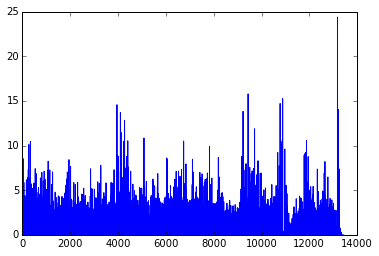

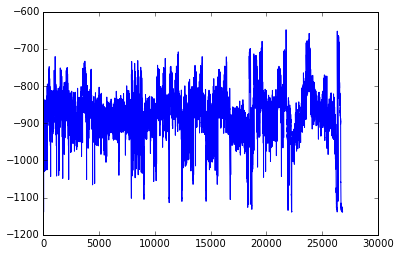

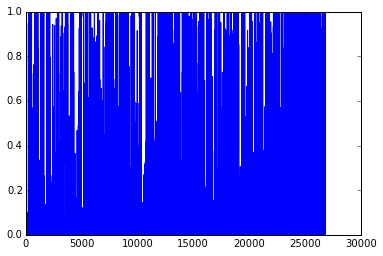

In [588]:
plt.figure()
plt.plot(sf)

plt.figure()
plt.plot(mfccs[0,:])

plt.figure()
plt.plot(chroma[0,:])

#### ii. Chords X (for CNN)

"Audio chord recognition with a hybrid neural network"

We use DNNs to learn discriminative features from a time- frequency representation of the audio. This is contrary to the common approach of extracting chroma features (and their many variants) as a preprocessing step. 

We transform the raw audio signal into a time-frequency representation with the constant-Q transform [6]. We first down-sample the audio to 11.025 kHz and compute the CQT with a hop-size of 1024 sam- ples. The CQT is computed over 7 octaves with 24 bins per octave yielding a 168 dimensional vector of real values. One of the advantages of using the CQT is that the rep- resentation is low dimensional and linear in pitch. Com- puting the short-time Fourier transform over long analysis windows would lead to a much higher dimensional rep- resentation. 

After extracting CQT frames for each track, we use a DNN to classify each frame to its corresponding chord label... We used DNNs with 3 hidden layers. We constrained all the layers to have the same number of hidden units to simplify the task of searching for good DNN architectures. The DNNs have a softmax output layer and the model parameters are obtained using maximum likelihood estimation.

Once the DNNs are trained, we use the activations of the final hidden layer of the DNN as features. In our experi- ments we observed that the acoustic model performance was improved (⇠ 3% absolute improvement in frame-level accuracy) if we provided each frame of features with context information. Context information was provided by performing mean and variance pooling over a context window around the central frame of interest [3]. A context window of length 2k + 1 is comprised of the central frame of interest, along with k frames before and after the central frame. In our experiments we found that a context window of 7 frames provided the best results.

We trained the network with mini-batch stochastic gradient descent. Instead of using learning rate update schedules, we use ADADELTA which adapts the learning rate over iterations [18]. In our experiments we found Dropout was essential to improve generalisation [16]. We found a Dropout rate of 0.3 applied to all layers of the DNN to be optimal for controlling overfitting. Once the models are trained, we use the model that performs best on the vali- dation set to extract features. In our experiments, the best performing model had 100 hidden units in each layer. Figure 1 is a graphical representation of the feature extraction pipeline. In section 6, we compare DNN acoustic models with different feature inputs.

We used a mini-batch size of 100 and early stopping for training. Training was stopped if the log-likelihood of the validation set did not increase for 20 iterations over the entire training set. Unlike the feature extraction stage, we do not discard any of the trained models. Instead of using only the best performing model on the validation set, we average the predictions of all the trained models to form an ensemble of DNNs [8] as the acoustic model. We found that simply averaging the predictions of the acoustic classifiers led to an absolute improvement of up to 3% on frame classification accuracies.

The results show that the performance of the acoustic model is greatly improved when the input features to the model are learnt by a DNN as opposed to CQT inputs. The performance of the acoustic model is further improved (3% absolute improvement) when mean and variance pooling is performed over a context window of DNN features.

In [589]:
from mad.audio.chroma import DeepChromaProcessor
from mad.processors import SequentialProcessor

def wav_to_chords(wav_file):
    
    # instantiate madmom deep chroma processor to extract chroma vectors
    dcp = DeepChromaProcessor()
    
    # create DeepChromaChordRecognitionProcessor to decode chord sequence from extracted chromas
    decode = DeepChromaChordRecognitionProcessor()
    
    # SequentialProcessor transcribes chords
    chordrec = SequentialProcessor([dcp, decode])
    chordrec(wav_file)
    
    # extract learned chord recognition features per:
    # Filip Korzeniowski and Gerhard Widmer, “A Fully Convolutional Deep Auditory Model for Musical Chord Recognition”
    proc = CNNChordFeatureProcessor()
    features = proc('tests/data/audio/sample2.wav')
    
    return(mfccs, superflux, chroma, wav_dur, superflux.shape[0])

mfccs, sf, chroma, wav_dur, wav_frames = wav_to_chords('data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.wav')

(13411,)
(13, 26823)
26823
26823
(12, 26823)


### b. Language Model: X (for RNN/LSTM)

Music, like language, exhibits temporal structure. Language model used to provide prior probability distribution for notes and chords. 

HMM: "A Supervised Approach To Musical Chord Recognition" is good example of using HMM on chord sequence in western music that greatly increases chord prediction accuracy. 

RNN: "An End-to-End Neural Network for Polyphonic Piano Music Transcription"

Two approaches:

First, as outlined in "An End-to-End Neural Network for Polyphonic Piano Music Transcription" (where they sampled the midi file for ground truth. Wow, seems that could be an easy way of fiding what freq's are turned off, on) and "Audio chord recognition with a hybrid neural network", you can use an RNN (LSTM) to create lanaguge model building note/chord prediction based on priors using all prior history (i.e., unlike HMM which only considers current state). 

However, you can't just do this in a gready fashion. That is, the correct prediction at time t is not known. Therefore, you can't just predict t+1 based on t (the HMM approach) or even t, t-1, t-2,... t-n (the RNN/LSTM) approach. So, you have to have a way of entertaining a number of possible options, settling on one or the other as evidence of its correct-ness accumulates. So, this requires a method of entertaining, sequentially, a range of solutions winnowing as you go, that's beam search. 

Beam search 1. generates a range of t+1 predictions sorted by probability estimate, 2. re-estimates the predictions as new X's arrive adding some and dropping others. Beam search has its own problems, some of which are addressed by hashing the beams, but that's beyond the scope. 

Second, if you assume knowledge of the song (either b/c user entered, or based on note search, prediction becomes a binary classification task i.e., does the current sound match the "predicted" sound. And, if not, provide the estimated sound. This model starts w/ knowledge of the song being played. Later, I'll add beam search soley for the purpose of identifying the song. 

*** 

As outlined in Section 3, we use RNNs with LSTM units for language modelling. The training data for the language models is obtained by sampling the ground truth chord transcriptions at the same frame-rate at which CQTs are extracted from the audio waveforms. We use RNNs with 2 layers of hidden recurrent units (100 LSTM units each) and an output softmax layer. Each training sequence was further divided into sub-sequences of length 100. 

The RNNs were trained with stochastic gradient descent on individual sub-sequences, without any mini-batching. Unlike the acoustic models, we observed that ADADELTA did not perform very well for RNN training. Instead, we used an initial learning rate of 0.001 that was linearly decreased to 0 over 1000 training iterations. We also found that a constant momentum rate of 0.9 helped training converge faster and yielded better results on the test set. We used early stopping and training was stopped if validation log- likelihood did not increase after 20 epochs. We used gra- dient clipping when the norm of the gradients was greater than 50 to avoid gradient explosion in the early stages of training.


# Train

## n. Fingerprint music

https://github.com/dpwe/audfprint

Audfprint is a python (and Matlab) script that can take a list of soundfiles and create a database of landmarks, and then subsequently take one or more query audio files and match them against the previously-created database.  The fingerprint is robust to things like time skews, different encoding schemes, and even added noise. It can match small fragments of sound, down to 10 sec or less.

# Output Results

## 1. midi-note

In [662]:
def midi_note(in_val, out_fmt):
    # takes midi value and returns (octave, note) or takes (octave, note) and returns midi value
    # midi <-> note source: 
    # http://www.electronics.dit.ie/staff/tscarff/Music_technology/midi/midi_note_numbers_for_octaves.htm
    
    notes = pd.DataFrame({'note': ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']})
    
    if out_fmt == "midi":
        octave = int(in_val[0])
        note = in_val[1]
        try:
            note_num = notes[notes['note'] == in_val[1]].index.tolist()[0]
        except IndexError:
            return('NA')
        
        midi = octave * 12 + note_num
        if midi > 127: midi = 'NA'
        return(midi)
    
    if out_fmt == "note":
        if in_val > 127:
            return('NA')
        else:
            midi = int(in_val)
            octave = int(midi / 12)
            note = notes.iloc[midi % 12][0]
        return((octave, note))
        
print(midi_note(45, "note")) # valid midi
      
# Note: if to/from freq needed: madmom.audio.filters.hz2midi(f, fref=440.0), mad.audio.filters.midi2hz(10, fref=440.0)

(3, 'A')


In [660]:
mt = m21.midi.MidiTrack(1)
dt1 = m21.midi.DeltaTime(mt)
dt1.time = 1024

me1 = m21.midi.MidiEvent(mt)
me1.type = "NOTE_ON"
me1.pitch = 45
me1.velocity = 94

dt2 = m21.midi.DeltaTime(mt)
dt2.time = 2048

me2 = m21.midi.MidiEvent(mt)
me2.type = "NOTE_ON"
me2.pitch = 45
me2.velocity = 0

n = m21.midi.translate.midiEventsToNote([dt1, me1, dt2, me2])
n.pitch
#n.duration.quarterLength
#n.volume.velocity

<music21.pitch.Pitch A2>

## 2. midi-chord

In [669]:
def midi_chord(in_vals, out_fmt):
    # takes up to 4 midi values (as tuple) occurring concurrently and returns chord or vice versa
    
    if out_fmt == "chord":
        
        mt = m21.midi.MidiTrack(1)
        track = []
        
        me1 = m21.midi.MidiEvent(mt)
        me2 = m21.midi.MidiEvent(mt)
        me3 = m21.midi.MidiEvent(mt)
        me4 = m21.midi.MidiEvent(mt)
        me5 = m21.midi.MidiEvent(mt)
        me6 = m21.midi.MidiEvent(mt)
        me7 = m21.midi.MidiEvent(mt)
        me8 = m21.midi.MidiEvent(mt)
        
        events = [me1, me2, me3, me4, me5, me6, me7, me8]
        
        dt0 = m21.midi.DeltaTime(mt)
        dt0.time = 0
        
        for i in range(len(in_vals)):
            
            track.append(dt0)
            
            events[i].type = "NOTE_ON"
            events[i].pitch = in_vals[i]
            events[i].velocity = 94
            
            track.append(events[i])
        
        dt1 = m21.midi.DeltaTime(mt)
        dt1.time = 2048
        track.append(dt1)
        
        incr = len(in_vals)
        
        for j in range(len(in_vals)):

            events[j+incr].type = "NOTE_OFF"
            events[j+incr].pitch = in_vals[j]
            events[j+incr].velocity = 0
            
            track.append(events[j+incr])
            
            track.append(dt0)
        
        return(m21.midi.translate.midiEventsToChord(track))
    
    elif out_fmt == "midi":
        print("poop")

c = midi_chord((45,46,47), "chord")
print(c.pitches[0])

A2


# Utilities

## 1. Compose midi

In [623]:
import music21 as m21

mt = m21.midi.MidiTrack(1)
dt1 = m21.midi.DeltaTime(mt)
dt1.time = 0

me1 = m21.midi.MidiEvent(mt)
me1.type = "NOTE_ON"
me1.pitch = 45
me1.velocity = 94
me1.t = 0

dt2 = m21.midi.DeltaTime(mt)
dt2.time = 0

me2 = m21.midi.MidiEvent(mt)
me2.type = "NOTE_ON"
me2.pitch = 46
me2.velocity = 94
me2.t = 0

dt3 = m21.midi.DeltaTime(mt)
dt3.time = 2048

me3 = m21.midi.MidiEvent(mt)
me3.type = "NOTE_OFF"
me3.pitch = 45
me3.velocity = 0
me3.t = 2048

dt4 = m21.midi.DeltaTime(mt)
dt4.time = 0

me4 = m21.midi.MidiEvent(mt)
me4.type = "NOTE_OFF"
me4.pitch = 46
me4.velocity = 0
me4.t = 2048

m21.midi.translate.midiEventsToChord([dt1, me1, dt1, me2, dt3, me3, dt1, me4])

print([dt1, me1, dt1, me2, dt3, me3, dt1, me4, dt1])

[<MidiEvent DeltaTime, t=0, track=1, channel=None>, <MidiEvent NOTE_ON, t=None, track=1, channel=None, pitch=45, velocity=94>, <MidiEvent DeltaTime, t=0, track=1, channel=None>, <MidiEvent NOTE_ON, t=None, track=1, channel=None, pitch=46, velocity=94>, <MidiEvent DeltaTime, t=2048, track=1, channel=None>, <MidiEvent NOTE_OFF, t=None, track=1, channel=None, pitch=45, velocity=0>, <MidiEvent DeltaTime, t=0, track=1, channel=None>, <MidiEvent NOTE_OFF, t=None, track=1, channel=None, pitch=46, velocity=0>, <MidiEvent DeltaTime, t=0, track=1, channel=None>]


how do you spot notes vs. echos vs. chords?
if you feed frames at 44100 hz, does it learn to recognize c# by its peak spectrum profile? or can it spot that as it develops frame by frame?

is it more efficient to run an onset / offset identifier (network or other) first to pull out the sounds and feed them to the network? 

how do you encode y? they've put down the onset and offset times. 
1. if you encode y=1 for all frames during that period, you're hoping it can spot the tone on the way up and down. that suggests a multi-frame CNN or a LSTM. theoretically, it could try to predict for every frame. but on way down lots of notes look the same. so, confidence s/b low and you'd not predict (default 0). 

2. if you think it's just going to find it based on relative peaks, take start time + 100ms

3. at 47kHz you're getting 800 frames / second. that's a lot. maybe sample less to get rougher image. train acustic model less and use song model to bring up accuracy i.e., taking output from last hidden nodes for acustic and song models 

READ HER ORIGINAL PIECE, THE OTHER ONE THAT USED HERS AND/OR THE ONE THAT MENTIONED 

1. if you have onset identifier,it needs to be an array of 0's as long as x. then at the time stamp, it needs to be incoded w/ the midi pitch? then you need to translate to the note

In [ ]:
for ds in datasets:
    
    # LogarithmicFilteredSpectrogram class accepts STFT, FramedSignal, Signal object or a file name as input.
    # It loads, filters and scales.

    log_filt_spec2 = mad.audio.spectrogram.LogarithmicFilteredSpectrogram('data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav',
                                                                      num_channels=1,
                                                                      num_bands=24)
    
    log_filt_spec = mad.audio.spectrogram.LogarithmicFilteredSpectrogram(ds,
                                                                         num_channels=1,
                                                                         num_bands=24)

    # SpectrogramDifference class calculates first order difference of a spectrogram. diff_frames sets the number
    # of frames how far apart the difference should be calculated. diff_max_bins performs maximum filtering. Or, 
    # positive_diffs returns only the positive differences. Resulting diff spectrogram has the same shape as the 
    # given one (np.diff() does not), with all frames < diff_frames set to zero.

    superflux_diff = mad.audio.spectrogram.SpectrogramDifference(log_filt_spec, positive_diffs=True, diff_max_bins=3)

    superflux_2 = np.sum(superflux_diff, axis=1)

    superflux_3 = mad.features.onsets.superflux(log_filt_spec)

    # we scale them to have the same range
    plt.figure()
    plt.plot(sf1 / sf1.max(), 'b')  # blue
    plt.plot(superflux1 / superflux1.max(), 'g')  # green
    plt.plot(superflux_2_1 / superflux_2_1.max(), 'r--')  # dashed red
    plt.plot(superflux_3_1 / superflux_3_1.max(), 'k:')  # dotted black


# Read

1. Files from directory, OR
2. Stream

# V1: Import piano train / test data

1. Take their lists of train and test data
2. Create list object
3. Feed it to a process to either iteratively or bulk load files from directory
4. Perform log scale transform of input wav
5. Come back to other features, chords


# Learn to map sound to notes

1. Take professional music sound files
2. Play, logging spectrum (frequency / time) and other attributes
    a. https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction, OR
    b. 
3. Predict notes based on sound
    a. input spectrum is the "X"
    b. sheet music notes are the "y" (notes A, B, C, etc.)

# V1: Generate harp note / chord train / test files

Garageband or other to generate:
1. individual instrument note (pitch?), chord by major/minor, octave, inversion
2. sequence files w/ varying amounts of spacing
3. mp3's of classical music for which you can easily veryify the notes


# V2: Standard: Fingerprint music files

In [ ]:
# use FFT, MFCC, etc to create a fignerprint of each of the music files s/t when user starts playing, you can take notes they've played and match 

# V2: Streaming: Extract note Sample

# V2: Streaming: Search / match sample to fingerprints

# Establish stream

Use pyaudio to instantiate stream for practice session

In [ ]:
WIDTH = 2
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()

def callback(in_data, frame_count, time_info, status):
    return (in_data, pyaudio.paContinue)

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                stream_callback=callback)

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)

stream.stop_stream()
stream.close()

p.terminate()

# Display mode

1. Accept song selection
2. Load / display sheet music
3. Listen for start
4. Recieve sounds / translate notes
5. Track progress w/ vertical bar
6. Spot repeats re-setting tracking bar

In [ ]:
# https://github.com/tyiannak/pyAudioAnalysis
# http://essentia.upf.edu/documentation/


# Evaluate mode

1. display mode functionality including tracking progress
2. record playing. overlay repeats. you're tracking stats. so, obj s/b:
    a. to get through song re-playing pieces as required, THEN
    b. to get through song cleanly
3. comparing played to professional
    a. option to play:
        i. metrinome 
        ii. professional a low volume
4. identify discrpancies (timing after prior note, incorrect note)
    a. Gaia, a C++ library with python bindings which implement similarity measures and classification on the results of audio analysis, and generate classification models that Essentia can use to compute high-level description of music.
5. show discrepancies
    a. accept tolerances (+/- time, other?)
    b. show played note in red (i.e., before/after, above/below).
6. show / log statistics
    a. accuracy
    b. similarity
    c. error types and frequency distribution
        i. early,
        ii. late
        iii. wrong note
    d. problem areas

# Interactive mode

1. evaluate mode functionality
2. prompt session info and imprint voice of user for command interface
    a. "this is []. the date is []. i'll be practicing for about [] minutes."
3. voice commands
    a. "replay [] notes" - defaults to: 5 notes, played version
    b. "replay base [] notes"
    c. "loop [] notes" - 
        ii. Loop [] notes / Stop Loop
2. 

# References

This project would not be possible without the invaluable assistance of:

## Training data

The MAPS piano data set. Roughly 40G of piano notes, chords, music assembled by V. Emiya for her PhD thesis at Telecom ParisTech/ENST in 2008 and in conjunction with R. Badeau, B. David for their paper "Multipitch estimation of piano sounds using a new probabilistic spectral smoothness principle"<cite data-cite="emiya2010multipitch"></cite>


In [ ]:
# for installing latex, bibtex and pdf-ing jupyter notenooks: https://www.youtube.com/watch?v=m3o1KXA1Rjk